# Prerequisites

In [167]:
!pip install --upgrade pip
!pip install -r requirements.txt

# Loading custom helpers

In [168]:
import requests  # Used for making HTTP requests to fetch online resources.

# URL of the raw file in the GitHub Gist
url = 'https://gist.githubusercontent.com/JMartinArocha/79e6f5c94ab6a8d3f0b2f57296395e76/raw/3d60d10fb336eb870cb03535929502bc8234abc9/ml_utilities.py'

# Fetching the content of the file
r = requests.get(url)

# Writing the content to a local file to ensure the utility script is available for import
with open('ml_utilities.py', 'w') as f:
    f.write(r.text)

# Importing the ml_utilities script after downloading it
import ml_utilities

# Loading dataset

In [169]:
import pandas as pd

source = './data/bank.csv'

df = pd.read_csv(source, sep=';')
columns = df.columns.values
ml_utilities.df_look(df)

First few rows of the DataFrame:
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  

Data types of the columns:
age           int64
job          object
marital   

# Data clean and normalization

In [170]:
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

columns_selected = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan', 'contact',  'duration','campaign', 'poutcome', 'y']
categorical_features = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'y']
numeric_features = ['age', 'balance', 'duration', 'campaign',]

df = df[columns_selected]


In [171]:
# from sklearn.preprocessing import OneHotEncoder

# onehot_encoder = OneHotEncoder(sparse_output=False)  # Use sparse=False para obtener una matriz densa
# encoded_features = onehot_encoder.fit_transform(df[categorical_features])
# # Crear un nuevo DataFrame con las columnas codificadas y concatenarlo con el original (excluyendo las categóricas originales)
# df_encoded = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names_out(categorical_features))
# df = df.drop(columns=categorical_features).join(df_encoded)


In [172]:
# from sklearn.preprocessing import OrdinalEncoder

# ordinal_encoder = OrdinalEncoder()
# df[categorical_features] = ordinal_encoder.fit_transform(df[categorical_features])


In [173]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply the label encoder to each categorical column using a loop
for column in categorical_features:
    df[column] = label_encoder.fit_transform(df[column])

In [174]:
min_max_scaler = MinMaxScaler()

# Escalar todas las columnas excepto la variable objetivo
# transformed_data = min_max_scaler.fit_transform(df.drop(columns='y'))
transformed_data = min_max_scaler.fit_transform(df)

# Convertir el array transformado de vuelta a un DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=df.columns)

# Añadir la variable objetivo de vuelta al DataFrame
# transformed_df['y'] = df['y']


In [175]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of components or the variance ratio to keep
pca = PCA(n_components=6)
X_pca = pca.fit_transform(transformed_data)

# Mostramos el porcentaje de varianza explicada por cada uno de los componentes seleccionados.
print(pca.explained_variance_ratio_)

# Visualizar la "importancia" de cada variable original del problema en las nuevas dimensiones
pd.DataFrame(np.matrix.transpose(pca.components_), index=df.columns)

[0.26445274 0.18531217 0.12481589 0.09489372 0.08979668 0.08210976]


,0,1,2,3,4,5
age,0.040490,-0.055506,0.019778,0.187935,-0.116498,-0.013950
job,0.114728,-0.022419,-0.103584,-0.398784,0.287579,-0.036371
marital,0.050828,0.061621,-0.130633,-0.595971,0.447077,0.230127
education,0.081631,0.036904,-0.087546,-0.221447,0.164286,0.014000
balance,0.003900,-0.001125,-0.008343,0.000061,-0.000451,0.004843
housing,-0.806814,0.537082,-0.035950,-0.062903,0.065943,-0.202778
loan,-0.029657,0.002243,0.949449,0.005504,0.300127,0.069904
contact,-0.547678,-0.715328,-0.106852,0.110027,0.194800,0.347809
duration,0.004461,0.008826,-0.019327,0.065634,0.090076,-0.035733
campaign,-0.001596,-0.007281,0.005893,-0.013444,-0.008037,-0.017551


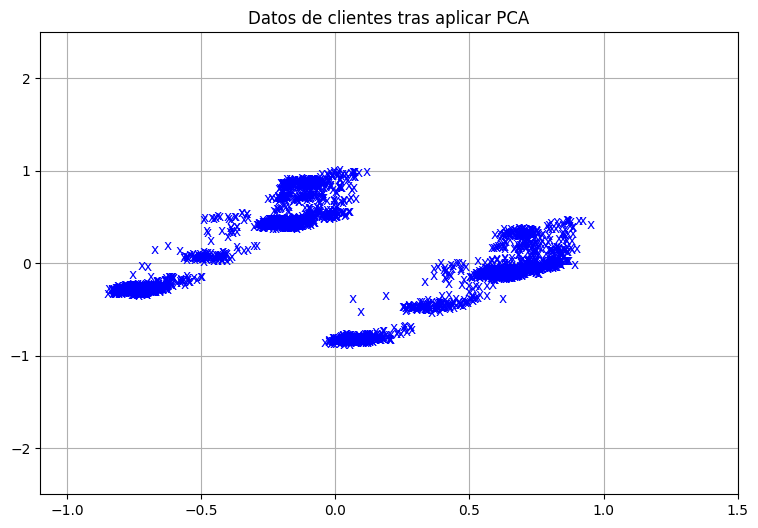

In [176]:
plt.figure(figsize=(9, 6))
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], 'x', color="b")
plt.xlim(-1.1, 1.5)
plt.ylim(-2.5, 2.5)
plt.title("Datos de clientes tras aplicar PCA")
plt.grid()
plt.show()

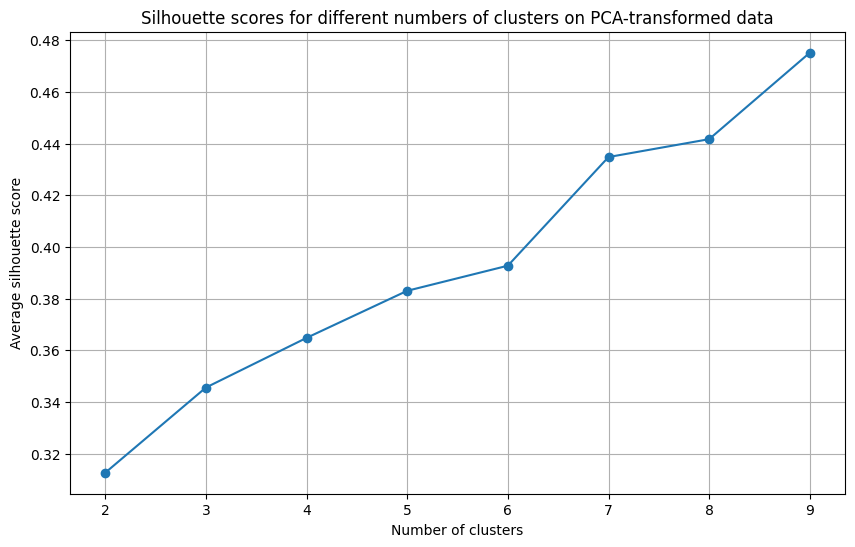

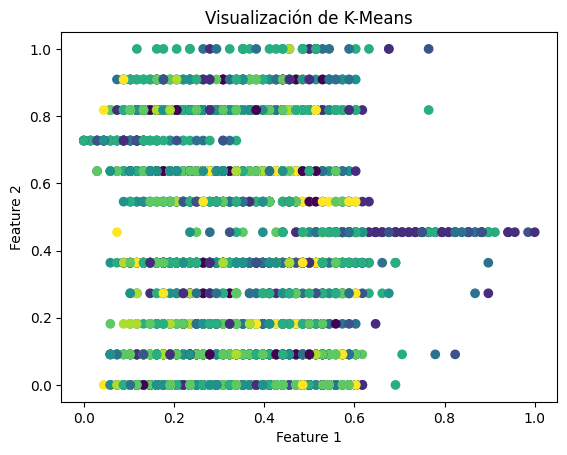

In [177]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Calculate silhouette scores for a range of cluster numbers
range_n_clusters = list(range(2, 10))
silhouette_avg = []
cluster_labels = False
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_pca)
    
    # Silhouette score
    silhouette_avg.append(silhouette_score(X_pca, cluster_labels))

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title('Silhouette scores for different numbers of clusters on PCA-transformed data')
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette score')
plt.grid(True)
plt.show()

# Opcional: Visualizar los resultados si es de baja dimensión
plt.scatter(transformed_df.iloc[:, 0], transformed_df.iloc[:, 1], c=cluster_labels, cmap='viridis')
plt.title("Visualización de K-Means")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


# Features selection

Average Distance after PCA	   1.26


/var/folders/0q/1jlxr5dd7031jdc6z52plxzh0000gn/T/ipykernel_31380/2174273332.py:16: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters_pca = cluster.hierarchy.linkage(D_pca, method='complete')


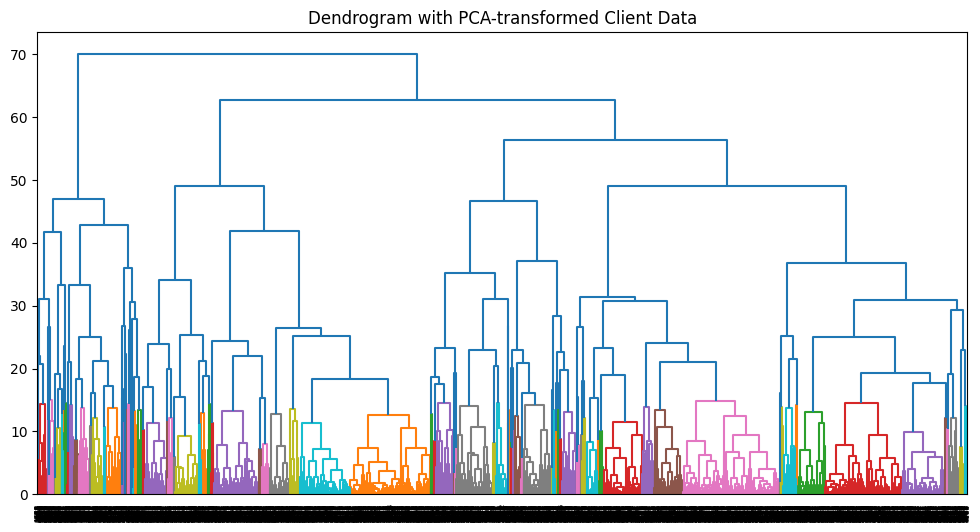

In [178]:
from scipy import cluster
import sklearn.metrics
import numpy as np
from scipy.spatial.distance import squareform

dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
# Compute the distance matrix on PCA-transformed data
D_pca = dist.pairwise(X_pca)
# D_pca = dist.pairwise(transformed_data)
D_pca_condensed = squareform(D_pca)

avD_pca = np.average(D_pca)
print("Average Distance after PCA\t {:6.2f}".format(avD_pca))

# Build dendrogram using PCA data
clusters_pca = cluster.hierarchy.linkage(D_pca, method='complete')
plt.figure(figsize=(12, 6))
cluster.hierarchy.dendrogram(clusters_pca, color_threshold=15)
plt.title("Dendrogram with PCA-transformed Client Data")
plt.show()





/var/folders/0q/1jlxr5dd7031jdc6z52plxzh0000gn/T/ipykernel_31380/3151724319.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters_method = cluster.hierarchy.linkage(D_pca, method=method)


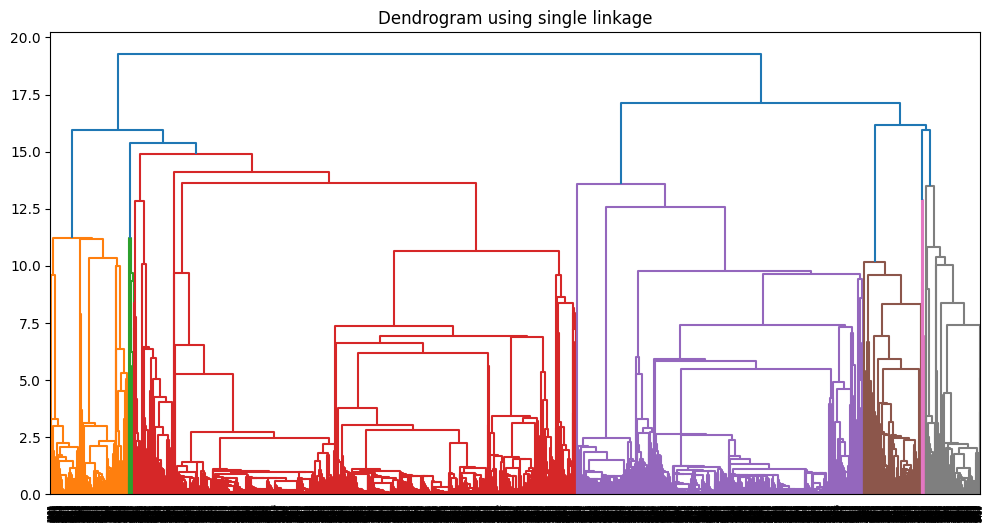

/var/folders/0q/1jlxr5dd7031jdc6z52plxzh0000gn/T/ipykernel_31380/3151724319.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters_method = cluster.hierarchy.linkage(D_pca, method=method)


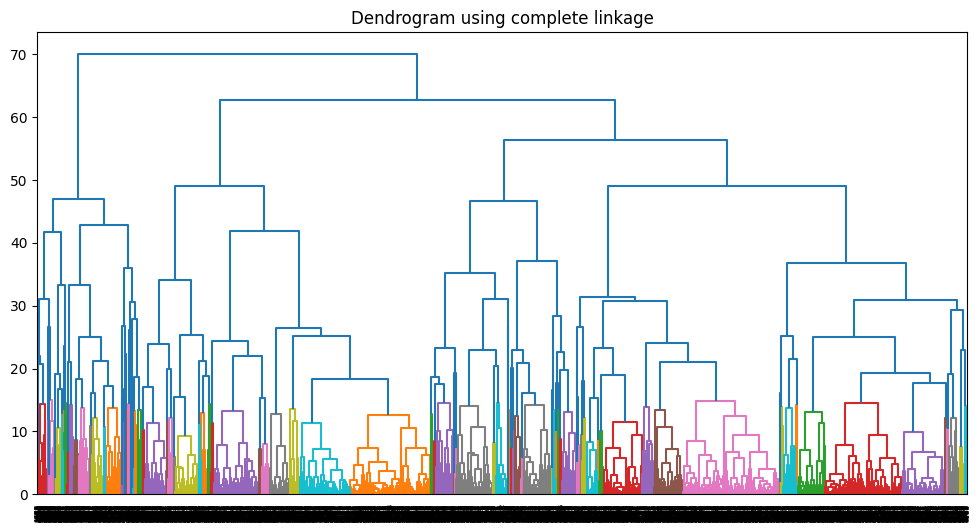

/var/folders/0q/1jlxr5dd7031jdc6z52plxzh0000gn/T/ipykernel_31380/3151724319.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters_method = cluster.hierarchy.linkage(D_pca, method=method)


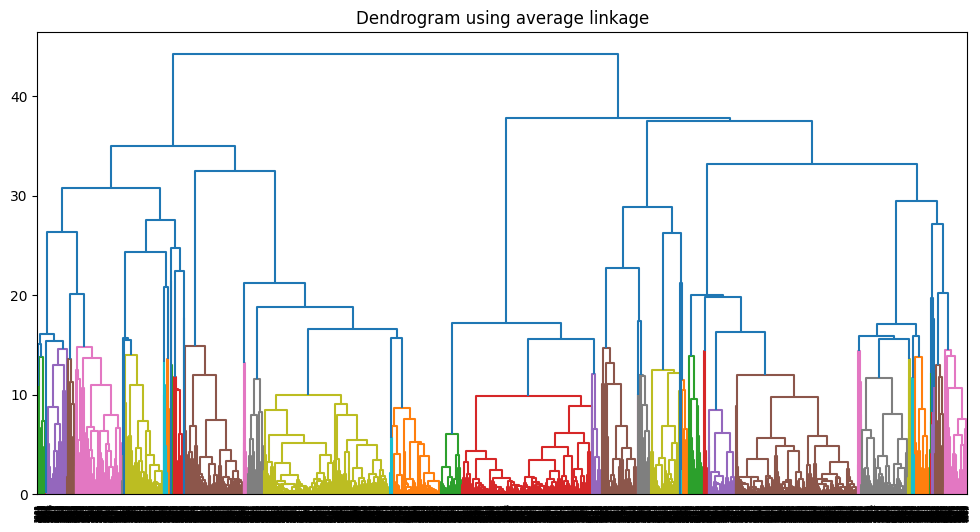

/var/folders/0q/1jlxr5dd7031jdc6z52plxzh0000gn/T/ipykernel_31380/3151724319.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters_method = cluster.hierarchy.linkage(D_pca, method=method)


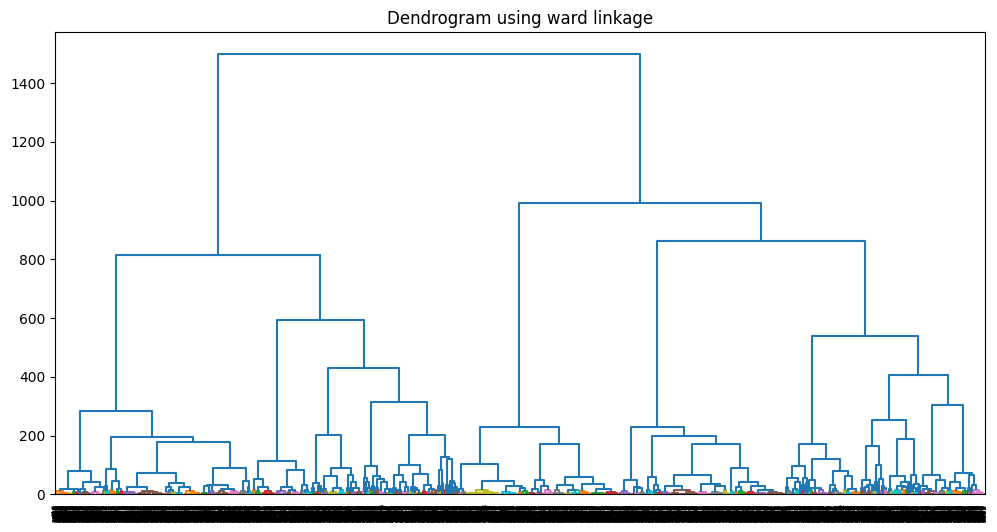

In [179]:
# Try different linkage methods to compare results
methods = ['single', 'complete', 'average', 'ward']
for method in methods:

    plt.figure(figsize=(12, 6))
    clusters_method = cluster.hierarchy.linkage(D_pca, method=method)
    cluster.hierarchy.dendrogram(clusters_method, color_threshold=15)
    plt.title(f"Dendrogram using {method} linkage")
    plt.show()


In [180]:
# Use the inconsistency coefficient to help decide where to cut the dendrogram
from scipy.cluster.hierarchy import inconsistent, fcluster

depth = 5  # Or another appropriate value
incons = inconsistent(clusters_pca, depth)
print(incons[-10:])

[[14.53787649 10.01033554 28.          2.70829816]
 [11.07380679  9.39942683 30.          3.27277357]
 [18.39565126  9.79588605 30.          2.49303056]
 [19.71583381  9.46899143 30.          2.84905054]
 [23.2228124  10.42589212 31.          2.27036577]
 [17.49133578 10.46791385 31.          3.01292946]
 [20.17577476  9.73050847 31.          2.97056165]
 [27.48521837  9.74946363 31.          2.96931136]
 [30.45053376 12.35057655 31.          2.60705481]
 [35.80273841 12.52217098 31.          2.73048376]]


In [181]:
# Cut dendrogram at a chosen depth
max_d = 15  # for example
clusters_cut = fcluster(clusters_pca, max_d, criterion='maxclust')
print(np.unique(clusters_cut))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


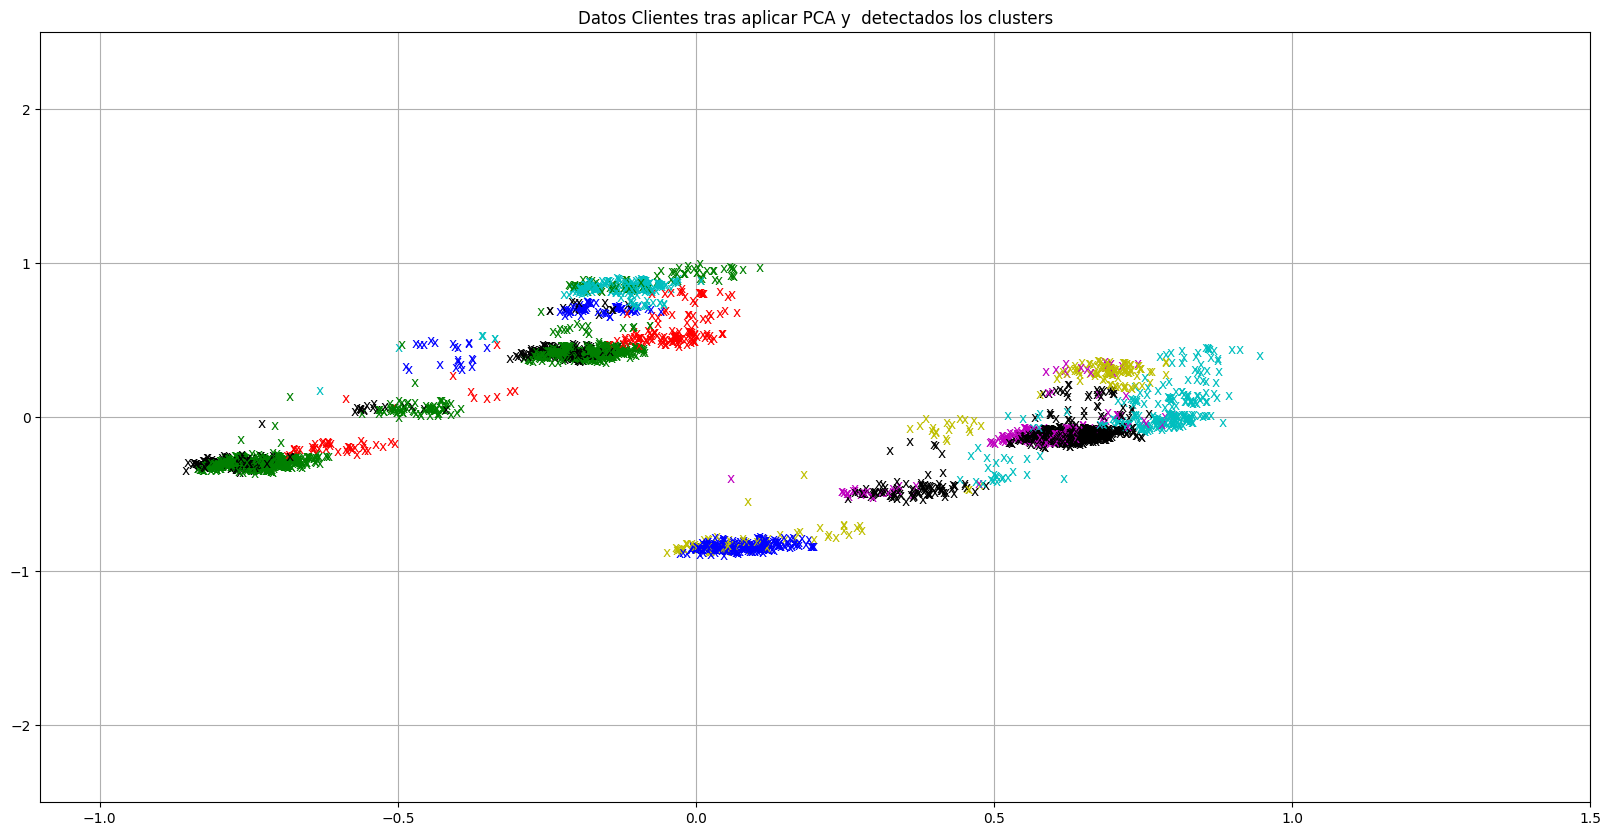

In [182]:
colores = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colores = np.hstack([colores] * 20)

plt.figure(figsize=(20, 10))
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], 'x', color=colores[clusters_cut[i]])
plt.xlim(-1.1, 1.5)
plt.ylim(-2.5, 2.5)
plt.grid()
plt.title("Datos Clientes tras aplicar PCA y  detectados los clusters")
plt.show()

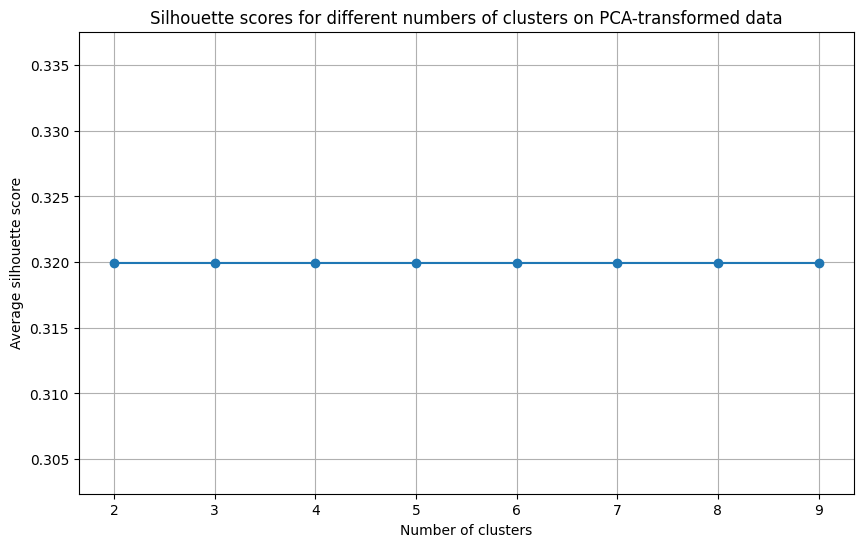

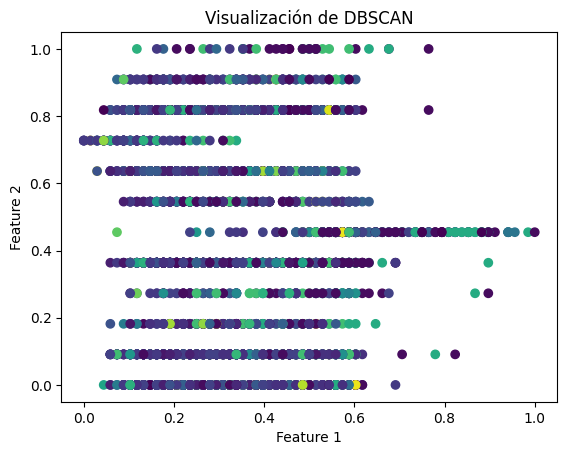

In [183]:
from sklearn.cluster import DBSCAN

# Ajustar DBSCAN
# eps es la distancia máxima entre dos muestras para que una sea considerada en el vecindario de la otra
# min_samples es el número mínimo de muestras en un vecindario para que un punto sea considerado un punto central


range_n_clusters = list(range(2, 10))
silhouette_avg = []
for n_clusters in range_n_clusters:
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(transformed_df.drop(columns='y'))
    
    # Silhouette score
    silhouette_avg.append(silhouette_score(transformed_data, cluster_labels))

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title('Silhouette scores for different numbers of clusters on PCA-transformed data')
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette score')
plt.grid(True)
plt.show()

# Opcional: Visualizar los resultados
plt.scatter(transformed_df.iloc[:, 0], transformed_df.iloc[:, 1], c=dbscan_labels, cmap='viridis')
plt.title("Visualización de DBSCAN")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


In [184]:

transformed_df['Cluster'] = clusters_cut  # Añade la columna de cluster al DataFrame
transformed_df.to_excel('datos.xlsx', index=False, engine='openpyxl')